## Table of Contents

* [Persistence method](#Persistence-method)
* [Percentile method](#Percentile-method)
* [Linear method](#Linear-method)
* [Kernel method](#Kernel-method)

In [1]:
import ee
from datetime import datetime
from IPython.display import Image, display,HTML
from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import download
import os

ee.Initialize()

# Select image to remove clouds
image_index = "LC81990332015238LGN00"
image_predict_clouds = ee.Image('LANDSAT/LC8_L1T_TOA_FMASK/'+image_index)

# Select region of interest
pol = [[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]]

region_of_interest = ee.Geometry.Polygon(pol)
datetime_image = datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start").getInfo()/1000).strftime("%Y-%m-%d %H:%M:%S")


In [2]:
# Vis image
imageRGB = image_predict_clouds.visualize(max=.3,bands=["B4","B3","B2"])
image_file_original = download.MaybeDownloadThumb(imageRGB.clip(region_of_interest),params={"dimensions": "400x400"})

## Persistence method

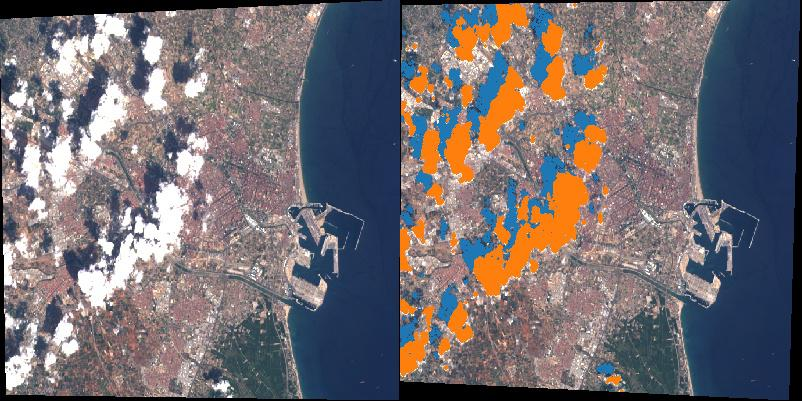

In [9]:
# Vis image + cloud mask
# Obtain cloud mask (2: cloud,1: shadow, 0: clear)
cloud_score_persistence,pred_persistence = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                                         method_pred="persistence")

cloud_score_persistence = cloud_score_persistence.updateMask(cloud_score_persistence)
cloud_score_threshold_vis = cloud_score_persistence.visualize(max=2,min=1,palette=['1f77b4', 'ff7f0e'])
mosaic = ee.ImageCollection([imageRGB, cloud_score_threshold_vis]).mosaic()
mosaic_clouds_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})

img_files_composite_per = download.MosaicImageList([image_file_original,mosaic_clouds_file],
                                                   [1,2])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore cloud mask</center>"%datetime_image))

## Percentile method

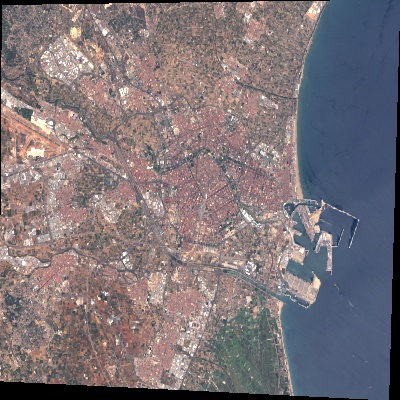

In [4]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                                      method_pred="percentile",
                                                                                       num_images=3)
percentile_pred_file = download.MaybeDownloadThumb(pred_percentile.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(percentile_pred_file),
        HTML("<center>Percentile prediction</center>"))

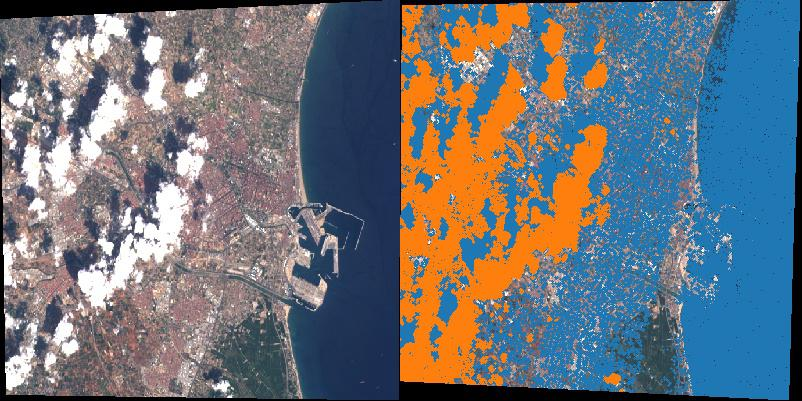

In [10]:
cloud_score_percentile = cloud_score_percentile.updateMask(cloud_score_percentile)
cloud_score_threshold_vis = cloud_score_percentile.visualize(max=2,min=1,palette=['1f77b4', 'ff7f0e'])
mosaic = ee.ImageCollection([imageRGB, cloud_score_threshold_vis]).mosaic()
mosaic_clouds_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})

img_files_composite_per = download.MosaicImageList([image_file_original,mosaic_clouds_file],
                                                   [1,2])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Linear method

In [6]:
from utils_ipl_uv import logging as log
from ee_ipl_uv import download
log.screen_logger(download.logger)
log.screen_logger(multitemporal_cloud_masking.logger)
download.logger.info("Turn on logging")

2018-01-31 16:30:29 ee_ipl_uv.download INFO     Turn on logging


2018-01-31 16:30:35 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2018-01-31 16:31:40 ee_ipl_uv.download INFO     Elapsed: 60s Status: RUNNING
2018-01-31 16:32:14 ee_ipl_uv.download INFO     ee.task COMPLETED 90s. Starting download from Google Drive
2018-01-31 16:32:14 ee_ipl_uv.download INFO     Downloading image pandas_ftcol12w118jx.csv from drive
2018-01-31 16:32:17 ee_ipl_uv.multitemporal_cloud_masking INFO     Size of downloaded ds: (31117, 34)


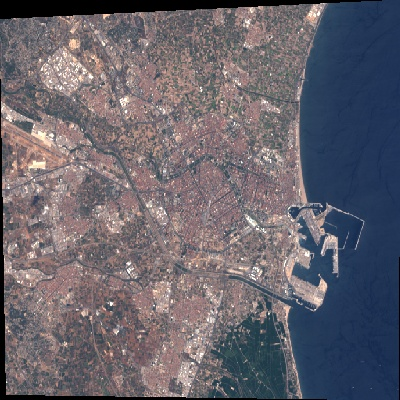

In [7]:
cloud_score_linear,pred_linear = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                               method_pred="linear",
                                                                               num_images=3)

pred_linear_file = download.MaybeDownloadThumb(pred_linear.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(pred_linear_file),
        HTML("<center>Linear method prediction</center>"))

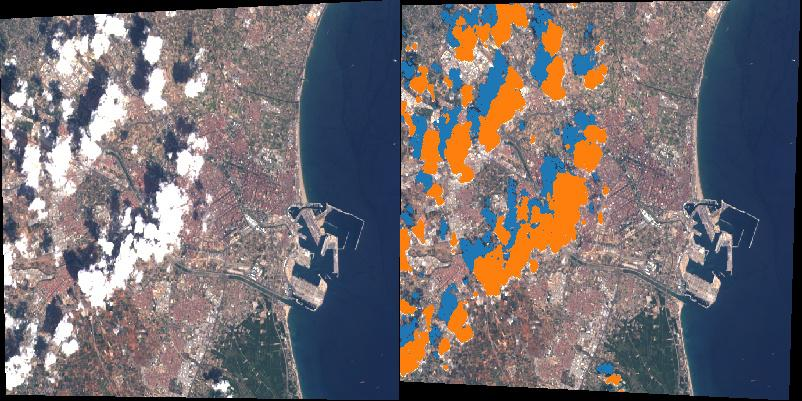

In [11]:
cloud_score_linear = cloud_score_linear.updateMask(cloud_score_linear)
cloud_score_threshold_vis = cloud_score_linear.visualize(max=2,min=1,palette=['1f77b4', 'ff7f0e'])
mosaic = ee.ImageCollection([imageRGB, cloud_score_threshold_vis]).mosaic()
mosaic_clouds_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})

img_files_composite_per = download.MosaicImageList([image_file_original,mosaic_clouds_file],
                                                   [1,2])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of linear method cloud mask</center>"%datetime_image))


## Kernel method

2018-01-31 16:36:53 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2018-01-31 16:37:15 ee_ipl_uv.download INFO     ee.task COMPLETED 20s. Starting download from Google Drive
2018-01-31 16:37:16 ee_ipl_uv.download INFO     Downloading image pandas_ftcoln_d_ra3t.csv from drive
2018-01-31 16:37:17 ee_ipl_uv.multitemporal_cloud_masking INFO     Size of downloaded ds: (31, 34)


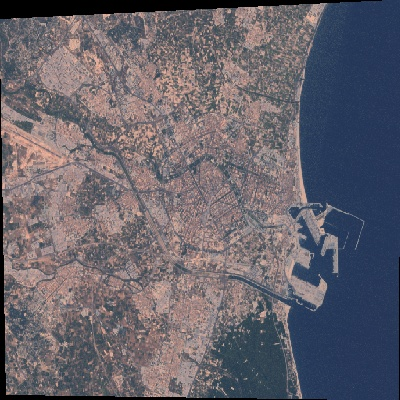

In [12]:
cloud_score_kernel,pred_kernel = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,
                                                                               region_of_interest,
                                                                               method_pred="kernel",num_images=3,
                                                                               params={"sampling_factor":0.00005,
                                                                                       "lmbda": 0.001,
                                                                                      "gamma": 0.011})

pred_kernel_file = download.MaybeDownloadThumb(pred_kernel.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(pred_kernel_file),
        HTML("<center>Kernel method prediction</center>"))

In [17]:
cloud_score_kernel = cloud_score_kernel.updateMask(cloud_score_kernel)
cloud_score_threshold_vis = cloud_score_kernel.visualize(max=2,min=1,palette=['1f77b4', 'ff7f0e'])
mosaic = ee.ImageCollection([imageRGB, cloud_score_threshold_vis]).mosaic()
mosaic_clouds_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest),
                                                 params={"dimensions": "400x400"})

img_files_composite_per = download.MosaicImageList([image_file_original,mosaic_clouds_file],
                                                   [1,2])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of kernel method cloud mask</center>"%datetime_image))

EEException: User memory limit exceeded.